# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [38]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
from sklearn.model_selection import LeaveOneOut, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, LeaveOneGroupOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import scipy
import json
# import category_encoders as ce
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from scipy.sparse import csr_matrix
import lightgbm
from local_utils import plots

%matplotlib inline

work_dir = '../output'
os.makedirs(f'{work_dir}', exist_ok=True)

In [68]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']

surragate_names = {'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie':'GRaNIE',
                   'ananse':'ANANSE',
                   'scglue':'scGLUE',
                   
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRaNIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKG': '#e7d2ec',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRaNIE': ':',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': '-',
}

In [42]:
COLORS

{'Random': '#E69F00',
 'CollectRI': '#56B4E9',
 'FigR': '#009E73',
 'CellOracle': '#F0E442',
 'GRaNIE': '#0072B2',
 'ANANSE': '#D55E00',
 'scGLUE': '#CC79A7'}

In [3]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


# Explanatory analysis 

In [4]:
grn_model_names = ['collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [5]:
peak_gene_model = ['figr', 'celloracle', 'granie']

grn_peak_gene_dict = {}
for name in peak_gene_model:
    model = pd.read_csv(f'../output/benchmark/peak_gene_models/{name}.csv', index_col=0)
    model.peak = model.source.str.replace('_','-')
    model.peak = model.source.str.replace(':','-')
    grn_peak_gene_dict[name] = model
grn_peak_gene_dict = {surragate_names[name]:grn for name, grn in grn_peak_gene_dict.items()}

/tmp/ipykernel_115735/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_115735/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')
/tmp/ipykernel_115735/1062260597.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model.peak = model.source.str.replace('_','-')


## Data structure 

In [7]:
from local_utils import network, plots

class Connectivity:
    def __init__(self, net, **kwargs):
        self.out_deg = network.degree_centrality(net, source='source', target='target',  **kwargs)
        self.in_deg = network.degree_centrality(net, source='target', target='source',  **kwargs)

class Explanatory_analysis:
    def __init__(self, net, peak_gene_net=None):
        # check duplicates
        dup_flag = False
        if 'cell_type' in net.columns:
            if net.duplicated(subset=['source','target','cell_type']).any():
                dup_flag = True
        else:
            if net.duplicated(subset=['source','target']).any():
                dup_flag = True
        if dup_flag:
            raise ValueError('The network has duplicated source target combinations.')
        # check basic stats
        self.n_links = net.shape[0]
        self.n_source = net.source.nunique()
        self.n_target = net.source.nunique()
        self.ratio_positive_negative =  (net.weight>=0).sum()/(net.shape[0])
        
        # connectivity
        self.tf_gene = Connectivity(net, normalize=True)
        if peak_gene_net is None:
            self.peak_gene = None
            self.n_cres = None
        else:
            self.peak_gene = Connectivity(peak_gene_net, normalize=False)
            self.n_cres = peak_gene_net.source.nunique()

        self.peak_annot = None
    def plot_cdf(self, values, ax=None, title=''):
        plots.plot_cumulative_density(values, ax=ax, title=title)
    def plot_connectivity(self):
        data_list = [self.tf_gene.out_deg, self.tf_gene.in_deg]
        if self.peak_gene is not None:
            data_list += [self.peak_gene.in_deg]
        for data in data_list:
            plots.plot_cumulative_density(data)
        

info_objs_dict = {}
for name in grn_models_dict.keys():
    print(name)
    net = grn_models_dict[name]
    net_peak_gene = grn_peak_gene_dict.get(name, None)

    info_obj = Explanatory_analysis(net=net, peak_gene_net=net_peak_gene)

    info_objs_dict[name] = info_obj

CollectRI
FigR
CellOracle
GRaNIE
scGLUE
Scenic+


## Topological analysis

### General stats

In [8]:
# regulatory links
links_n = {}
for name, grn in grn_models_dict.items():
    if 'cell_type' in grn.columns: # for cell specific grn models, take the mean
        n_grn = grn.groupby('cell_type').size().mean()
    else:
        n_grn = len(grn)
    links_n[name] = n_grn
print(links_n)

# positive vs negative
regulatory_effect_dict = {}
for name, grn in grn_models_dict.items():
    print('-----', name)
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    if 'cell_type' in grn.columns:
        celltype_counts = grn_sign.groupby('cell_type').weight.value_counts()
        signs = [celltype_counts[celltype_counts.index.get_level_values('weight')==1].mean(), celltype_counts[celltype_counts.index.get_level_values('weight')==-1].mean()]
    else:
        signs = grn_sign.weight.value_counts().values # 'positive, negative:
    if len(signs)==1:
        signs = [signs[0], 0]
    regulatory_effect_dict[name] = signs
regulatory_effect_dict
# tfs and targets
target_genes_dict = {}
tfs_dict = {}
for name, grn in grn_models_dict.items():
    tfs_dict[name] = grn.source.unique() 
    target_genes_dict[name] = grn.target.unique().tolist()


print('number of TFs')
tfs_dict_n =  {key:len(values) for key,values in tfs_dict.items()}
print(tfs_dict_n)
print('number of targets')
target_genes_dict_n = {key:len(values) for key,values in target_genes_dict.items()}
target_genes_dict_n

# peaks
peaks_dict = {}
peaks_n_dict = {}
for name, df in grn_peak_gene_dict.items():
    peaks_dict[name] = df.source.unique()
    peaks_n_dict[name] = df.source.nunique()

{'CollectRI': 43178, 'FigR': 24292, 'CellOracle': 54693.0, 'GRaNIE': 10679, 'scGLUE': 51567, 'Scenic+': 33537}
----- CollectRI
----- FigR
----- CellOracle
----- GRaNIE
----- scGLUE
----- Scenic+
number of TFs
{'CollectRI': 1186, 'FigR': 389, 'CellOracle': 557, 'GRaNIE': 180, 'scGLUE': 439, 'Scenic+': 140}
number of targets


#### Plot

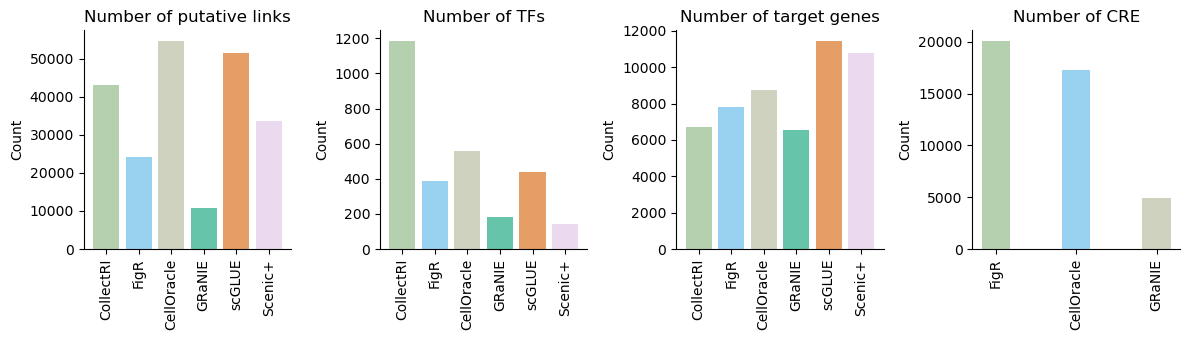

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.5)) 
color = 'grey'
## number of links
ax = axes[0]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(links_n.keys(), links_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of putative links')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')

# Rotate category names for better readability
plt.xticks(rotation=45)
## number of TFs
ax = axes[1]
ax.bar(tfs_dict_n.keys(), tfs_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of TFs')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
## number of target 
ax = axes[2]

ax.bar(target_genes_dict_n.keys(), target_genes_dict_n.values(), color=colors,  alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of target genes')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

## number of peaks 
ax = axes[3]
colors = [COLORS[name] for name in links_n.keys()]
ax.bar(peaks_n_dict.keys(), peaks_n_dict.values(), color=colors, width=0.35, alpha=.6)
# ax.set_xlabel('GRN models')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of CRE')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
# ax.set_yscale('log')
plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/stats_regulatory_elements.png', dpi=150, transparent=True)

#### Regulatory signs

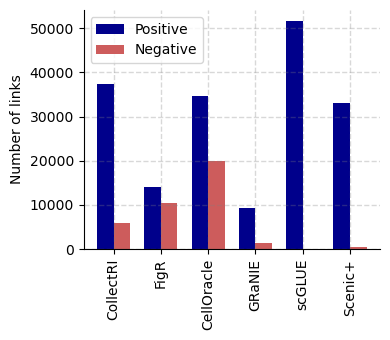

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5)) 
# regulatory role 
data = regulatory_effect_dict
categories = list(data.keys())
positive_counts = [data[category][0] for category in categories]
negative_counts = [data[category][1] for category in categories]
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color=COLORS['Positive'])
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color=COLORS['Negative'])
ax.set_ylabel('Number of links')
# ax.set_title('Regulatory sign')
ax.set_xticks(x)
ax.set_xticklabels(categories)
# ax.set_xticklabels([category for category in categories])
ax.tick_params(axis='x', rotation=90)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')
# ax.set_yscale('log')
ax.legend()
plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/regulatory_signs.png', dpi=150, transparent=True)

## Connectivity

### Centrality

Text(0.5, 1.0, 'In-degree centrality: CRE-gene')

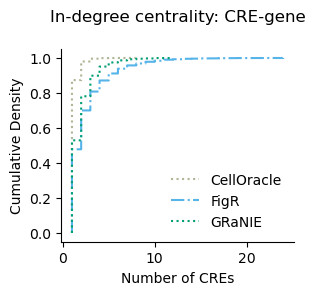

In [69]:
# peak gene: in degree
def plot_cumulative_density(data, title='', ax=None, s=1, **kwdgs):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    ax.step(sorted_data, cdf, where='post', label=title, **kwdgs)

    ax.set_xlabel('Number of CREs')
    ax.set_ylabel('Cumulative Density')
    ax.spines[['top','right']].set_visible(False)
    # ax.grid(True)
    return fig, ax

fig, ax = plt.subplots(figsize=(3, 2.5))
for i_plot, name in enumerate(['CellOracle','FigR','GRaNIE']):
    values = info_objs_dict[name].peak_gene.in_deg
    plot_cumulative_density(values, title=name, ax=ax, linestyle=LINESTYLES[name], c=COLORS[name])
ax.legend(frameon=False)
ax.set_title('In-degree centrality: CRE-gene', pad=20)

Text(0.5, 1.0, 'In-degree centrality: TF-gene')

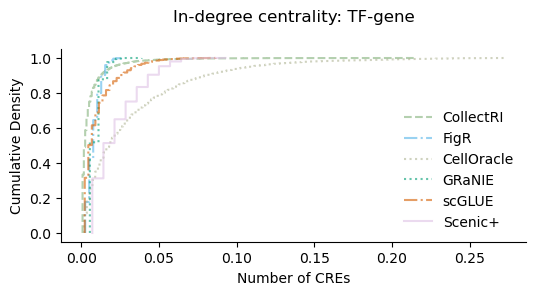

In [70]:
# tf gene: in degree
fig, ax = plt.subplots(figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    values = info_objs_dict[name].tf_gene.in_deg
    plot_cumulative_density(values, title=name, ax=ax, linestyle=LINESTYLES[name], c=COLORS[name], alpha=.6)
ax.legend(frameon=False)
ax.set_title('In-degree centrality: TF-gene', pad=20)

Text(0.5, 1.0, 'Out-degree centrality: TF-gene')

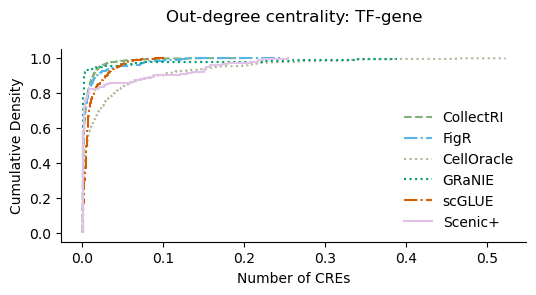

In [71]:
# tf gene: out degree 
fig, ax = plt.subplots(figsize=(6, 2.5))
for i_plot, name in enumerate(grn_models_dict.keys()):
    values = info_objs_dict[name].tf_gene.out_deg
    plot_cumulative_density(values, title=name, ax=ax, linestyle=LINESTYLES[name], c=COLORS[name])
ax.legend(frameon=False)
ax.set_title('Out-degree centrality: TF-gene', pad=20)

### Intersection of GRN elements

In [73]:
grn_fused_dict = {}
for name, grn in grn_models_dict.items():
    grn['link'] = grn['source']+'_'+grn['target']
    grn_fused_dict[name] = grn['link'].drop_duplicates().reset_index(drop=True)

 ####### Links
 ####### target genes
 ####### TFs
 ####### CRE


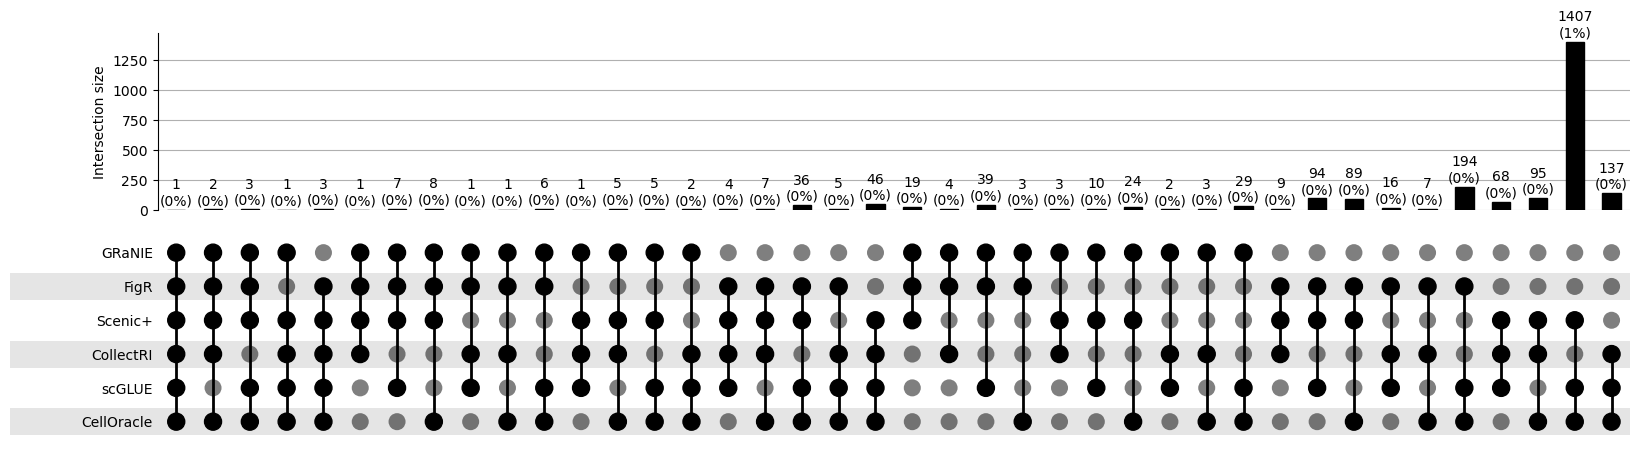

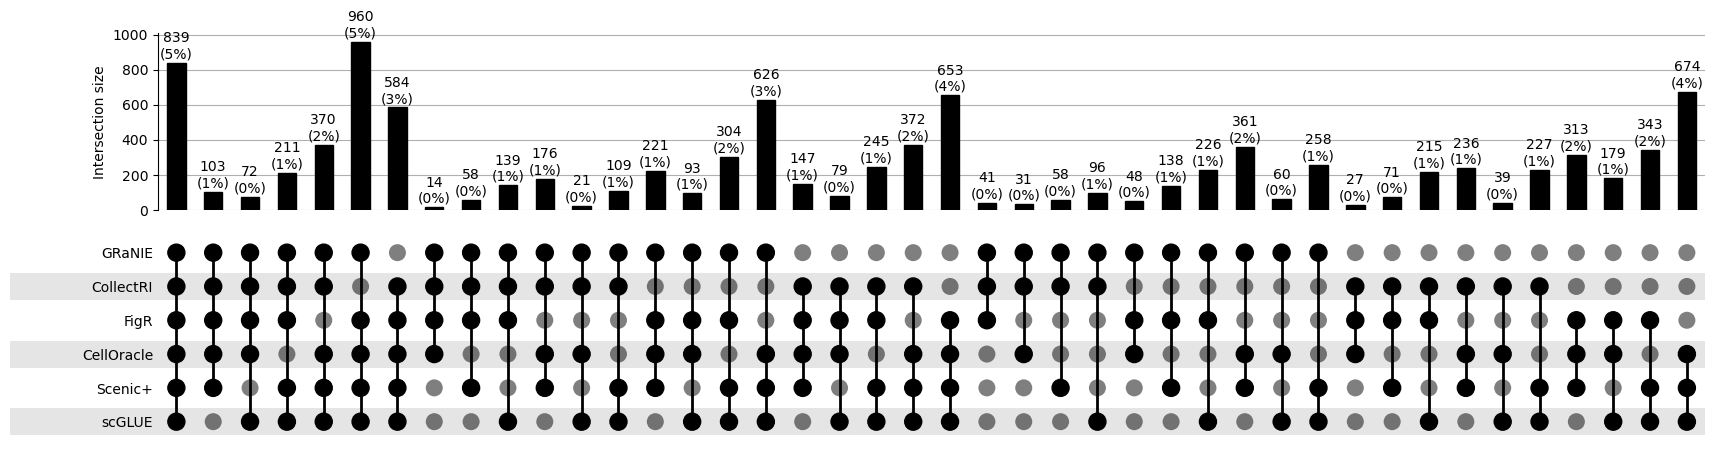

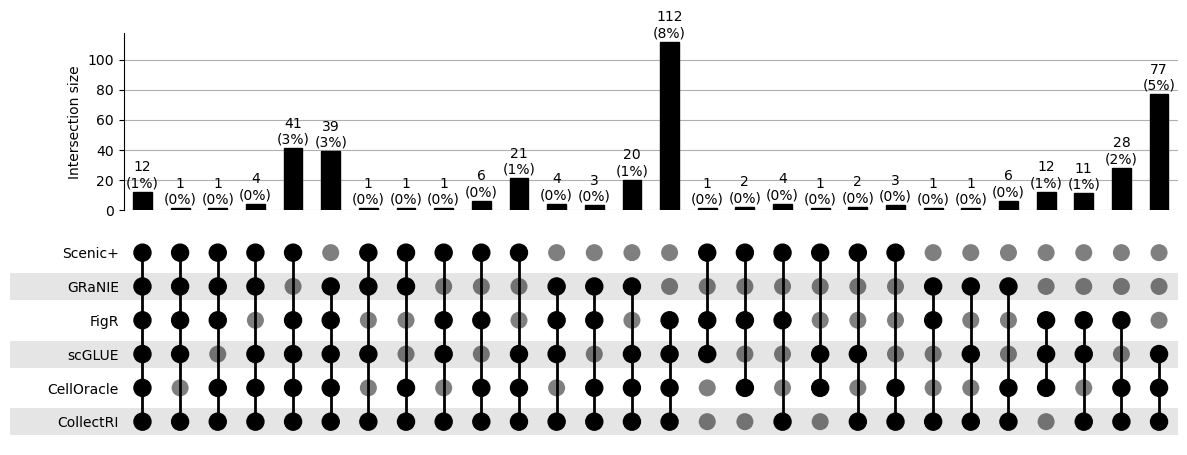

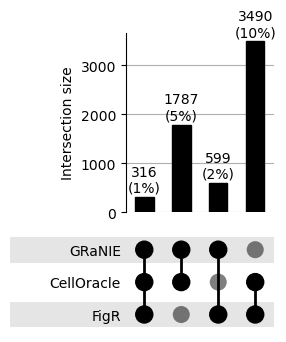

In [74]:
from upsetplot import from_indicators, plot
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")
# Create a set of all unique genes
def convert_df(data):
    all_genes = list(set(gene for genes in data.values() for gene in genes))
    # Initialize DataFrame
    df = pd.DataFrame(index=all_genes)
    # Populate DataFrame
    for key, genes in data.items():
        df[key] = df.index.isin(genes)
    return df


print(' ####### Links')
fig = plt.figure()
df_interactions = convert_df(grn_fused_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions),fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35, #side length
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/links_interactions.png', dpi=150, transparent=True)

print(' ####### target genes')
fig = plt.figure()
df_interactions = convert_df(target_genes_dict)    
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0)
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/targets_interactions.png', dpi=150, transparent=True)


print(' ####### TFs')
fig = plt.figure()
df_interactions = convert_df(tfs_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree', 
        # min_subset_size =100, 
        min_degree=3,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
fig.savefig(f'{work_dir}/benchmark/figs/TFs_interactions.png', dpi=150, transparent=True)

print(' ####### CRE')
fig = plt.figure()
df_interactions = convert_df(peaks_dict)
out_dict = plot(from_indicators(indicators=lambda a: a==True, data=df_interactions), fig=fig, 
        show_counts=True, 
        show_percentages = '{:.0%}',
        sort_by='-degree',  #-cardinality
        # min_subset_size =100, 
        min_degree=2,
        facecolor='black',
        other_dots_color=.5, 
        shading_color =0.1, 
        with_lines = True,
        element_size = 35,
        intersection_plot_elements=5,
        totals_plot_elements = 0
        )
matrix_ax, shading_ax, totals_ax, intersections_ax = out_dict['matrix'], out_dict['shading'], out_dict['totals'], out_dict['intersections']
#     fig.savefig(f'{work_dir}/benchmark/figs/CRE_interactions.png', dpi=150, transparent=True)

## Annoation

### Types of peaks

In [94]:
%load_ext rpy2.ipython

,0,1,2
0,chr6,33576788,33577679
1,chr1,22846199,22847091
2,chr1,22846199,22847091
3,chr1,22846199,22847091
4,chr1,22846199,22847091
...,...,...,...
12419,chr17,81884230,81885173
12420,chr17,81884230,81885173
12421,chr17,81884230,81885173
12422,chr17,81884230,81885173


In [120]:
temp_dir = f'{work_dir}/benchmark/temp/peak_annotation/'
def format_peak_for_annotate(grn_ct):
    grn_ct[['chr', 'start', 'end']] = grn_ct.source.str.split(r'[:\-_]', expand=True)
    grn_ct['range'] = grn_ct['start'] + '-' + grn_ct['end']

    # Drop the now separate 'start' and 'end' columns if no longer needed
    grn_ct.drop(columns=['start', 'end'], inplace=True)


    
os.makedirs(temp_dir, exist_ok=True)
for name, grn_ct in grn_peak_gene_dict.items():
    format_peak_for_annotate(grn_ct)

    peaks = grn_ct[['chr','range']]
    peaks.to_csv(f'{temp_dir}{name}.txt', index=False)
method_names = list(grn_peak_gene_dict.keys())

In [121]:
%%R -i method_names -i temp_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

# install.packages("IRanges")
# install.packages("GenomicRanges")
# install.packages("ggplot2")
# install.packages("TxDb.Hsapiens.UCSC.hg38.knownGene")

library(IRanges)
library(GenomicRanges)
library(ggplot2)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

for (name in method_names){
  peaks = read.table(paste0(temp_dir, name, '.txt'), sep=',', header = TRUE)
  peaks = GRanges(peaks$chr, IRanges(peaks$range))
  peaks_annotated = suppressMessages(ChIPseeker::annotatePeak(
      peaks,
      tssRegion = c(-1000, 1000), # extended from -5kb to 5
      TxDb = txdb,
      level = "transcript", 
      assignGenomicAnnotation = TRUE,  # the default
      genomicAnnotationPriority = c("Promoter", "5UTR", "3UTR", "Exon", "Intron",
                                    "Downstream", "Intergenic"),  # the default
      annoDb = NULL,
      sameStrand = FALSE, # the default
      ignoreOverlap = FALSE, # the default
      ignoreUpstream = FALSE, # the default
      ignoreDownstream = FALSE, # the default
      overlap = "TSS", # the default
      verbose = TRUE # the default
    ))
  peaks_annotated_df = as.data.frame(peaks_annotated)
  write.table(peaks_annotated_df, paste0(temp_dir, name, '_annot.txt'), sep=',', row.names = FALSE)
}


>> preparing features information...		 2024-06-17 01:16:13 
>> identifying nearest features...		 2024-06-17 01:16:13 
>> calculating distance from peak to TSS...	 2024-06-17 01:16:13 
>> assigning genomic annotation...		 2024-06-17 01:16:13 
>> assigning chromosome lengths			 2024-06-17 01:16:18 
>> done...					 2024-06-17 01:16:18 
>> preparing features information...		 2024-06-17 01:16:19 
>> identifying nearest features...		 2024-06-17 01:16:19 
>> calculating distance from peak to TSS...	 2024-06-17 01:16:19 
>> assigning genomic annotation...		 2024-06-17 01:16:19 
>> assigning chromosome lengths			 2024-06-17 01:16:23 
>> done...					 2024-06-17 01:16:23 
>> preparing features information...		 2024-06-17 01:16:24 
>> identifying nearest features...		 2024-06-17 01:16:24 
>> calculating distance from peak to TSS...	 2024-06-17 01:16:24 
>> assigning genomic annotation...		 2024-06-17 01:16:24 
>> assigning chromosome lengths			 2024-06-17 01:16:28 
>> done...					 2024-06-17 01:16

In [134]:
map_={'Intron':'Intron', 'Exon':'Exon', 'Promoter':'Promoter', 'Distal':'Distal Intergenic', "3'":"3' UTR", 'Downstream':'Downstream (<=300)', "5'":"5' UTR"}

annotation_dict = {}
for name in method_names:
    ann_df = pd.read_csv(f'{temp_dir}{name}_annot.txt')
    ann = ann_df.annotation.str.split(' ', expand=True)[0]
    ann = ann.map(map_)
    value_counts = ann.value_counts()
    sum_values = value_counts.sum()
    value_ratio = (value_counts/sum_values)*100
    annotation_dict[name] = value_ratio.to_dict()
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
# peak_annotation_df.index = peak_annotation_df.index.map(surragate_names)
peak_annotation_df

,Intron,Promoter,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
FigR,36.989504,30.980451,18.574342,6.605979,4.457046,1.552007
CellOracle,0.527868,98.782576,0.271067,0.199734,0.085600,0.009511
GRaNIE,22.013844,55.891822,12.942692,4.370573,3.187379,1.150998


/tmp/ipykernel_115735/1500704113.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0:
/tmp/ipykernel_115735/1500704113.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] > 1:
/tmp/ipykernel_115735/1500704113.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = f'{counts[j]:.1f} %'


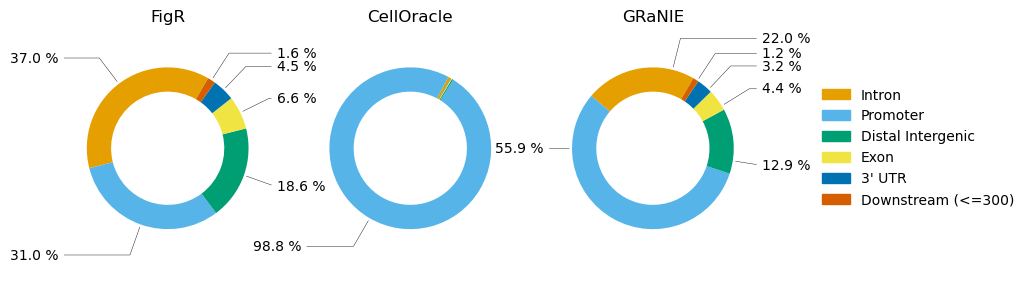

In [193]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, len(peak_annotation_df.index) + 1, figsize=(12, 3.5))

colors = colors_blind
startangle = 60

theta_offsets = [2 , 2, 5]
for i, (ax, idx) in enumerate(zip(axes[:-1], peak_annotation_df.index)):
    ax.set_title(idx + '\n', fontsize=12)
    counts = peak_annotation_df.loc[idx]
    wedges, texts = ax.pie(counts, colors=colors, wedgeprops=dict(width=0.3), startangle=startangle, radius=1)

    bbox_props = dict(fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-", linewidth=0.3), zorder=0, va="center", fontsize=10)

    for j, p in enumerate(wedges):
        if counts[j] == 0:
            continue
        ang = (p.theta2 - p.theta1) / theta_offsets[i] + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        if counts[j] > 1:
            text = f'{counts[j]:.1f} %'
            ax.annotate(text, xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                        horizontalalignment=horizontalalignment, **kw)

# Create a legend in the last subplot
ax = axes[-1]
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, peak_annotation_df.columns)]
leg = ax.legend(handles=patches, bbox_to_anchor=(1.15, 0.77), fontsize=10)
leg.get_frame().set_linewidth(0.0)
ax.axis('off')

# plt.tight_layout()
plt.show()


# HVGs analysis


In [167]:
bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_integrated.h5ad')

n_hvgs = 3000

### Highly devient genes: raw counts
Germain et al. instead proposes to use deviance for feature selection which works on raw counts [Germain et al., 2020]. Deviance can be computed in closed form and quantifies whether genes show a constant expression profile across cells as these are not informative. Genes with constant expression are described by a multinomial null model, they are approximated by the binomial deviance. Highly informative genes across cells will have a high deviance value which indicates a poor fit by the null model (i.e., they don’t show constant expression across cells).

In [ ]:
%load_ext rpy2.ipython

In [163]:
%%R -i work_dir
library(scry)
library(zellkonverter)
library(SingleCellExperiment)
options(digits=5, max.print=100)  # Adjust numbers as needed



adata = readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

/root/anaconda3/envs/py10/lib/python3.10/site-packages/rpy2/rinterface.py:186: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  openrlib.rlib.R_tryEval(
/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    r

In [164]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


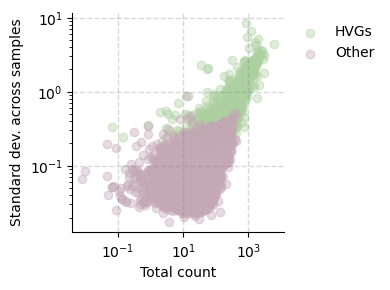

In [168]:
genes = hvgs_sce
bulk_adata.X = bulk_adata.layers['scgen_pearson']
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = bulk_adata.var
var['sum'] = bulk_adata.X.sum(axis=0)
var['std'] = bulk_adata.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='#add0a0')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Other', alpha=0.4, color='#c4a8b5')


ax.set_ylabel('Standard dev. across samples')
ax.set_xlabel('Total count')
ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(alpha=0.3, linestyle='--', linewidth=1, color='grey')

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

### GRN targets vs HVGs 

In [176]:
genesets_dict = {**{name:grn.target.unique() for name, grn in grn_models_dict.items()}, **{'HKG':housekeeping_genes}}

In [177]:
hvgs = hvgs_sce

hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {}
n_random = 100
for name, geneset in genesets_dict.items():
    pert_genes = bulk_adata.var_names
    shared_genes = np.intersect1d(geneset, pert_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(pert_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
hvgs_intersection_ratio_dict

{'collectRI': 0.35218631178707227,
 'figr': 0.3111812593454062,
 'celloracle': 0.3059245960502693,
 'granie': 0.2857142857142857,
 'scglue': 0.32481376830208064,
 'scenicplus': 0.2808685319217889,
 'HKG': 0.18445772843723313}

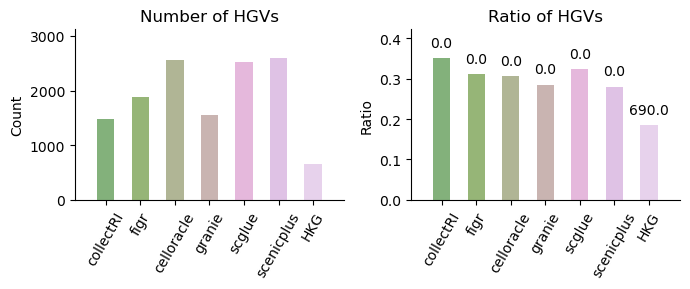

In [178]:
hvgs = hvgs_sce

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)


def plot_bar(ax, data, y_label, title, top_p_dict=None):
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    colors = [COLORS[surragate_names.get(key, key)] for key in data.keys()]
    
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color=colors, label='SCRE')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text] + 0.02, txt, ha='center', va='bottom')


width = .5

plot_bar(axes[0], hvgs_intersection_n_dict, y_label='Count', title='Number of HGVs')
plot_bar(axes[1], hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio of HGVs', top_p_dict=top_p_dict)

# axes[1].legend(loc='upper left', bbox_to_anchor=(1,1), frameon=True)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)
plt.show()

# GRN Weight-based regression 

In [ ]:
norm_method = None

bulk_adata = ad.read('../output/preprocess/bulk_adata_integrated.h5ad')
bulk_index = ['sm_name', 'cell_type', 'donor_id', 'plate_name', 'row']
# data = bulk_adata.layers[f'X_norm_{norm_method}']
# data = bulk_adata.X
data = bulk_adata.layers['seurat']

df_train = pd.DataFrame(data, columns=bulk_adata.var.index, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]))

df_train.head()


/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


index                                                            A1BG  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.456954   
                      Myeloid cells Donor 1  010        A   -0.575009   
                      NK cells      Donor 1  010        A   -0.367954   
                      T cells       Donor 1  010        A    0.665574   
MK-5108               B cells       Donor 1  010        A    1.214316   

index                                                        A1BG-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.178955   
                      Myeloid cells Donor 1  010        A    0.106276   
                      NK cells      Donor 1  010        A    1.007036   
                      T cells       Donor 1  010        A    0.382907   
MK-5108               B cells       Donor 1  010        A    2.541742   

index                                                             A2M  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.675342   
                      Myeloid cells Donor 1  010        A    1.310987   
                      NK cells      Donor 1  010        A    0.003117   
                      T cells       Donor 1  010        A   -0.564866   
MK-5108               B cells       Donor 1  010        A   -0.675492   

index                                                         A2M-AS1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.672942   
                      Myeloid cells Donor 1  010        A   -0.652688   
                      NK cells      Donor 1  010        A    1.063749   
                      T cells       Donor 1  010        A   -0.452515   
MK-5108               B cells       Donor 1  010        A   -0.668740   

index                                                           A2MP1  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.480910   
                      Myeloid cells Donor 1  010        A   -0.480910   
                      NK cells      Donor 1  010        A    1.116476   
                      T cells       Donor 1  010        A   -0.178416   
MK-5108               B cells       Donor 1  010        A   -0.480910   

index                                                            AAAS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    0.037427   
                      Myeloid cells Donor 1  010        A   -0.674204   
                      NK cells      Donor 1  010        A    0.727295   
                      T cells       Donor 1  010        A   -1.417941   
MK-5108               B cells       Donor 1  010        A   -0.964661   

index                                                            AACS  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A    1.854700   
                      Myeloid cells Donor 1  010        A    0.057568   
                      NK cells      Donor 1  010        A   -0.414309   
                      T cells       Donor 1  010        A   -0.381207   
MK-5108               B cells       Donor 1  010        A    0.874025   

index                                                           AAGAB  \
sm_name               cell_type     donor_id plate_name row             
TIE2 Kinase Inhibitor B cells       Donor 1  010        A   -0.730331   
                      Myeloid cells Donor 1  010        A    1.033481   
                      NK cells      Donor 1  010        A    0.313179   
                      T cells       Donor 1  010   

In [ ]:
cell_type_index = df_train.index.get_level_values('cell_type').astype(str) 

In [ ]:
# grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
grn_model_names = ['celloracle', 'scenicplus']

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

# grn_models_dict = {}
# baselines = ['positive_control', 'negative_control']
baselines = ['positive_control']
for name in baselines:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/baseline_models/{name}.csv', index_col=0)


In [ ]:
grn_models_dict.keys()

dict_keys(['positive_control', 'negative_control'])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
# from skranger.ensemble import RangerForestRegressor
# from sklearn.multioutput import MultiOutputRegressor


class lightgbm_wrapper:
    def __init__(self, params):
        self.params =  params
        
    def fit_predict(self, X_train, Y_train, X_test):
        y_pred_list = []
        for i in range(Y_train.shape[1]):
            regr = 
            regr.fit(X_train, Y_train[:, i])
            y_pred = regr.predict(X_test)
            y_pred_list.append(y_pred)
            
        return np.stack(y_pred_list, axis=1)
    def predict(self)

In [ ]:
class Regression_analysis_GRN_weight:
    ''' Uses GRN weights as feature space to predict perturbation data.
    '''
    def __init__(self, 
            **kwargs) -> None:
        self.run_groups(**kwargs)

    def run_groups(self, df_train:pd.DataFrame,
            net: pd.DataFrame, 
            group_index: str, 
            reg_type: str = 'GB', 
            params: dict = {}, 
            verbose: int = 0
            ) -> None:
        cell_type_index = df_train.index.get_level_values('cell_type')

        self.r2_scores_groups = {}
        n_groups = len(group_index.unique())
        pbar = tqdm.tqdm(group_index.unique(), desc="Group cv")
        for group_i, group in enumerate(pbar):
            # subset df for cell type 
            mask = group_index==group
            df_subset = df_train[mask]

            cell_type = df_subset.index.get_level_values('cell_type').unique()[0]

            # net is cell type dependent or not 
            if 'cell_type' in net:
                net_celltype = net[net.cell_type==cell_type]
            else:
                net_celltype = net.copy()
            # match net and df in terms of shared genes
            grn_net = self.match_data(df_train, net_celltype)

            # pivot to have gene*tf matrix
            grn_net = net_celltype.pivot(index='target', columns='source', values='weight').fillna(0)
            if verbose >=2:
                print(f'X (genes, TFs): {grn_net.shape}, Y (genes, samples): {Y.shape}')
            # fill random weights for the missing genes
            grn_net = self.add_random_weights(df_subset, grn_net)
            
            # get training data
            X = grn_net.values
            Y = df_subset.values.T              
            # run cv 
            self.r2_scores_groups[group] = self.run_cross_validation(X, Y, reg_type)
    def get_results(self) -> dict[str, float]:
        return self.r2_scores_groups

    @staticmethod
    def add_random_weights(df_train, net):
        net_genes = net.index.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        missing_genes = np.setdiff1d(df_train.columns, shared_genes)
        tfs_n = net.columns.unique().shape[0]
        
        sparsity = (net.values==0).sum()/net.values.size
        ratios = [sparsity, (1-sparsity)/2, (1-sparsity)/2]
        shape = (missing_genes.shape[0], tfs_n)
        X_random = np.random.choice([0, -1, 1], size=shape, p=ratios)
        net = pd.concat([net, pd.DataFrame(X_random, columns=net.columns, index=missing_genes)])
        net = net.reindex(df_train.columns)
        return net
    @staticmethod
    def match_data(df_train: pd.DataFrame, net_celltype: pd.DataFrame) -> pd.DataFrame:
        # match net and df in terms of shared genes 
        net_genes = net_celltype.target.unique()
        shared_genes = np.intersect1d(net_genes, df_train.columns)
        net_celltype = net_celltype[net_celltype.target.isin(shared_genes)]

        return net_celltype
    @staticmethod
    def cv_5(genes_n):
        '''5 fold standard'''
        num_groups = 5
        group_size = genes_n // num_groups
        groups = np.repeat(np.arange(num_groups), group_size)
        if genes_n % num_groups != 0:
            groups = np.concatenate((groups, np.arange(genes_n % num_groups)))
        np.random.shuffle(groups)
        return groups
    @classmethod
    def run_cross_validation(cls, X: np.ndarray, Y: np.ndarray, reg_type: str):
        # determine regressor 
        if reg_type=='ridge':
            regr = MultiOutputRegressor(Ridge(**params))
        else:
            regr = MultiOutputRegressor(lightgbm.LGBMRegressor(**params), n_jobs=10)

        # define cv scheme
        cv_groups = cls.cv_5(X.shape[0])

        Y_pred_stack = []
        Y_true_stack = []
        unique_cv_groups = np.unique(cv_groups)
        
        for cv_group in unique_cv_groups:
            mask_va = cv_groups==cv_group
            mask_tr = ~mask_va

            X_tr, Y_tr = X[mask_tr,:], Y[mask_tr,:]
            X_va, Y_true = X[mask_va,:], Y[mask_va,:]

            regr.fit(X_tr, Y_tr)
            Y_pred = regr.predict(X_va)

            Y_pred_stack.append(Y_pred)
            Y_true_stack.append(Y_true)
        y_pred = np.concatenate(Y_pred_stack, axis=0)
        y_true = np.concatenate(Y_true_stack, axis=0)
        r2_score_group = r2_score(y_true, y_pred, multioutput='variance_weighted') #uniform_average', 'variance_weighted
        return r2_score_group


In [ ]:
reg_type = 'GB'
manipulate = None #'signed', None 'shuffled'


In [ ]:
if True:
    os.makedirs(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/', exist_ok=True)

    # grn_model = 'celloracle'
    # net = grn_models_dict[grn_model]

    for i_model, (grn_model, net) in enumerate(grn_models_dict.items()):
        print(grn_model)
        print(f'{i_model+1}/{len(grn_models_dict)} in run')
        # shuffle or 
        if manipulate=='shuffled':
            net = grn_shuffle(net)
        elif manipulate=='signed':
            net = sign_grn(net)
        # print(grn_model)
        if reg_type=='ridge':
            params = dict(random_state=32, alpha = 100) 
        elif reg_type=='rf':
            params = dict(random_state=32, n_estimators=100, boosting_type="rf", n_jobs=10, 
            feature_fraction = 0.8, verbosity=-1 )
            # params = dict(seed =32, n_estimators=100)
        elif reg_type=='GB':
            params = dict(random_state=32, n_estimators=100, min_samples_leaf=2, min_child_samples=1, feature_fraction=0.05, verbosity=-1)

        else:
            raise ValueError('define first')
        obj = Regression_analysis_GRN_weight(df_train=df_train, net=net, group_index=cell_type_index, reg_type=reg_type, params=params, verbose=0)
        output = obj.get_results() 
        with open(f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_{manipulate}.json', 'w') as f:
            json.dump(output, f)


celloracle
1/3 in run


Group cv:   0%|          | 0/4 [5:05:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
output

{'B cells': -0.01214258258784739,
 'Myeloid cells': -0.00621784775835288,
 'NK cells': -0.014287911579543329,
 'T cells': -0.006072343868746141}

In [ ]:
#scenicplus
output

{'B cells': 0.014848572451914436,
 'Myeloid cells': 0.14944866993126402,
 'NK cells': 0.020442075940622223,
 'T cells': 0.09782135325298896}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


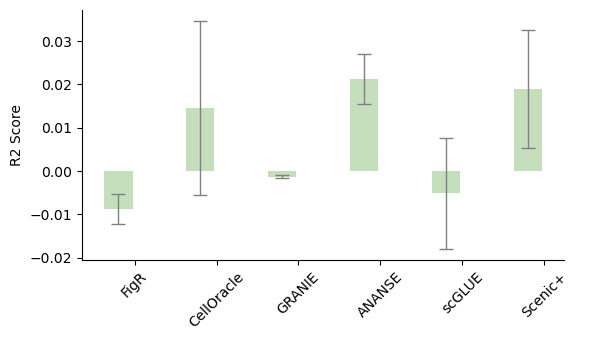

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5)) 

legend_colors = ['#add0a0', '#c4a8b5', 'orange']

offset = .4
width = .35
score_lower_t = -1

handles = []  # To store legend handles
for i_plot, norm_method in enumerate([None]):
    # --- read the scores
    model_names = []
    mean_score_list = []
    scores_all_list = []
    sig_sign_list = []
    # for grn_model in grn_models_dict.keys():
    for grn_model in ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']:
        file = f'{work_dir}/benchmark/scores/{reg_type}/{norm_method}/{grn_model}_None.json'
        if not os.path.isfile(file):
            print(f'{file} doesnt exist')
            continue
        with open(file, 'r') as f:
            scores_dict = json.load(f)
            scores_all = np.asarray(list(scores_dict.values()))
            mean_score = np.mean(scores_all) #mean_score_r2
        model_names.append(grn_model)
        mean_score_list.append(mean_score)
        scores_all_list.append(scores_all)
    
    # plot 
    x_ticks = range(len(model_names))
    x_positions = [xx + (offset * (i_plot - 0.5)) for xx in x_ticks]
    error_kw = {'ecolor': 'gray', 'capsize': 5, 'capthick': 1, 'elinewidth': 1}

    y_positions = np.mean(scores_all_list, axis=1) 
    std = np.std(scores_all_list, axis=1)
    # norm_method = surragate_names[norm_method]
    ax.bar(x_positions, height=y_positions, yerr=std, capsize=5, alpha=0.7,  width=width, color=legend_colors[i_plot], error_kw=error_kw, label=norm_method)


    ax.set_xticks(x_ticks)
    ax.set_xticklabels([surragate_names[name] for name in model_names], rotation=45)
    ax.set_ylabel('R2 Score')
    # ax.set_ylim([0, .7])

    #-- annotate 
    # for ii, x_pos in enumerate(x_positions):
    #     y_pos = y_positions[ii] + std[ii] + .2 * i_plot
    #     txt = f'{mean_score_list[ii]:.2f}'
    #     ax.text(x_pos, y_pos, txt, ha='center', color='black', fontsize=8)
ax.legend(loc=(1.01,.8), frameon=False)
# # Correcting text annotations with offset adjustments

for side in ['right', 'top']:
    ax.spines[side].set_visible(False)

plt.tight_layout()

fig.savefig(f'{work_dir}/benchmark/figs/r2_scores.png', dpi=150, transparent=True)

plt.show()